<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/PRUEBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy

In [2]:
import simpy
import numpy as np
from random import seed, random
import matplotlib.pyplot as plt
from scipy.stats import t

In [27]:
# Parámetros del sistema
no_autobuses = 1        # Cantidad de autobuses en la parada (inicialmente 1)
capacidad_autobus = 19  # Capacidad del autobús
tc_min = 1              # Tiempo mínimo de embarque (minutos)
tc_max = 3              # Tiempo máximo de embarque (minutos)
ll = 1 / 5              # Tasa de llegada de clientes (1 cada 5 minutos)
mu = 1 / 15             # Tasa de llegada de autobuses (1 cada 15 minutos)
clientes = 50           # Total de clientes a simular en cada corrida
cifras = 2              # Cantidad de cifras decimales

# Semilla para reproducibilidad
semilla = 13
seed(semilla)

In [28]:
# Listas para almacenar resultados
LTLL, LC, LS = [], [], []

In [29]:
# Función de simulación de la parada de autobuses
def parada_autobus(env, parada, nc, texto=False):
    for i in range(nc):
        # Tiempo hasta la próxima llegada de cliente siguiendo distribución exponencial
        tll = np.random.exponential(scale=1/ll)
        yield env.timeout(tll)
        LTLL.append(env.now)
        if texto:
            print(f'----Ha llegado el cliente número {i} en el minuto {round(env.now, cifras)}----')
        env.process(cliente(env, parada, i, texto))

def cliente(env, parada, num, texto=False):
    global tc_min, tc_max, LC, LS
    with parada.request() as request:
        yield request
        tc = np.random.uniform(tc_min, tc_max)  # Tiempo de embarque aleatorio
        LC.append(tc)
        if texto:
            print(f'****Cliente {num} inicia el embarque en el minuto {round(env.now, cifras)}****')
        yield env.timeout(tc)
        LS.append(env.now)
        if texto:
            print(f'xxxCliente {num} termina el embarque en el minuto {round(env.now, cifras)}xxx')

def llegada_autobus(env, parada, texto=False):
    global mu
    while True:
        # Tiempo entre llegadas de autobuses siguiendo distribución exponencial
        t_llegada_autobus = np.random.exponential(scale=1/mu)
        yield env.timeout(t_llegada_autobus)

        num_pasajeros = len(parada.queue)  # Pasajeros esperando en la cola
        if texto:
            print(f'Autobús llega a la parada a los {round(env.now, cifras)} minutos')

        # Determinar cuántos pasajeros recogerá el autobús
        if num_pasajeros > 0:
            pasajeros_a_recoger = min(num_pasajeros, capacidad_autobus)
            for _ in range(pasajeros_a_recoger):
                parada.release(parada.request())  # Se simula la subida de los pasajeros al autobús
            if texto:
                print(f'Autobús recoge a {pasajeros_a_recoger} pasajeros en la parada a los {round(env.now, cifras)} minutos')

def exp(n):
    long_cola = []
    tiempo_esp = []
    uso = []
    autobuses_necesarios_totales = []

    for _ in range(n):
        global LTLL, LC, LS
        LTLL, LC, LS = [], [], []

        env = simpy.Environment()
        parada = simpy.Resource(env, capacity=no_autobuses)
        env.process(parada_autobus(env, parada, clientes, texto=False))
        env.process(llegada_autobus(env, parada, texto=False))
        env.run(until=1000)

        LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
        num_boarded = len(LS)
        LTLL = LTLL[:num_boarded]
        LC = LC[:num_boarded]
        t_esp = sum(LS - LTLL - LC)
        fin_sim = env.now

        long_cola.append(t_esp / fin_sim)
        tiempo_esp.append(t_esp / clientes)
        uso.append(100 * sum(LC) / fin_sim)

        # Calcular el número total de autobuses necesarios
        # Basado en la cantidad total de pasajeros en cola y la capacidad del autobús
        total_pasajeros = sum(1 for _ in LTLL)  # Total de pasajeros atendidos
        total_autobuses = np.ceil(total_pasajeros / capacidad_autobus)  # Autobuses necesarios
        autobuses_necesarios_totales.append(total_autobuses)

    return long_cola, tiempo_esp, uso, autobuses_necesarios_totales  # Asegurarse de que se devuelven cuatro valores

# Graficar el estado del sistema en el tiempo
def graf_estado(l, titulo):
    g = []
    n = len(l)
    for i in range(n):
        g.append(np.mean(l[:i+1]))
    plt.plot(g, 'lightblue')
    m = np.mean(l)
    s = np.std(l, ddof=1)
    plt.hlines(m, 0, n, color='r', linestyles='dotted')
    plt.hlines(m + 1.96 * s / np.sqrt(n), 0, n, color='g', linestyles='dashed')
    plt.hlines(m - 1.96 * s / np.sqrt(n), 0, n, color='g', linestyles='dashed')
    plt.title(titulo)
    plt.xlabel('Iteraciones')
    plt.show()


In [30]:

# Example usage with printing:
env = simpy.Environment()
parada = simpy.Resource(env, capacity=no_autobuses)
env.process(parada_autobus(env, parada, clientes, texto=True)) # Set texto to True for printing
env.process(llegada_autobus(env, parada, texto=True)) # Set texto to True for printing
env.run(until=100) # Run for a shorter time to see some output

long_cola, tiempo_esp, uso, autobuses_necesarios_totales = exp(10) #Example call to exp



Autobús llega a la parada a los 8.34 minutos
----Ha llegado el cliente número 0 en el minuto 12.01----
****Cliente 0 inicia el embarque en el minuto 12.01****
xxxCliente 0 termina el embarque en el minuto 14.97xxx
----Ha llegado el cliente número 1 en el minuto 15.63----
****Cliente 1 inicia el embarque en el minuto 15.63****
----Ha llegado el cliente número 2 en el minuto 16.37----
xxxCliente 1 termina el embarque en el minuto 18.3xxx
****Cliente 2 inicia el embarque en el minuto 18.3****
xxxCliente 2 termina el embarque en el minuto 19.63xxx
----Ha llegado el cliente número 3 en el minuto 30.0----
****Cliente 3 inicia el embarque en el minuto 30.0****
----Ha llegado el cliente número 4 en el minuto 31.8----
xxxCliente 3 termina el embarque en el minuto 32.73xxx
****Cliente 4 inicia el embarque en el minuto 32.73****
xxxCliente 4 termina el embarque en el minuto 34.03xxx
Autobús llega a la parada a los 38.05 minutos
----Ha llegado el cliente número 5 en el minuto 40.06----
****Cliente

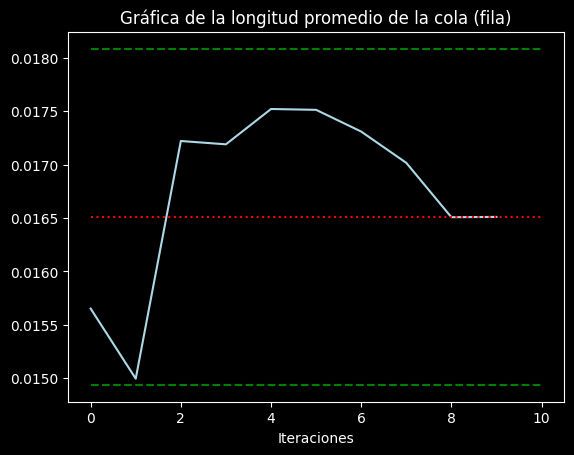

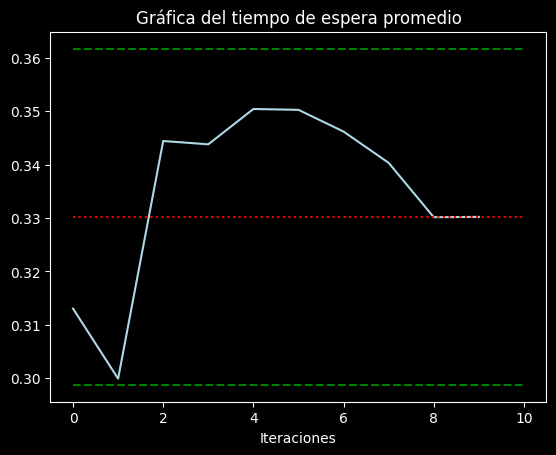

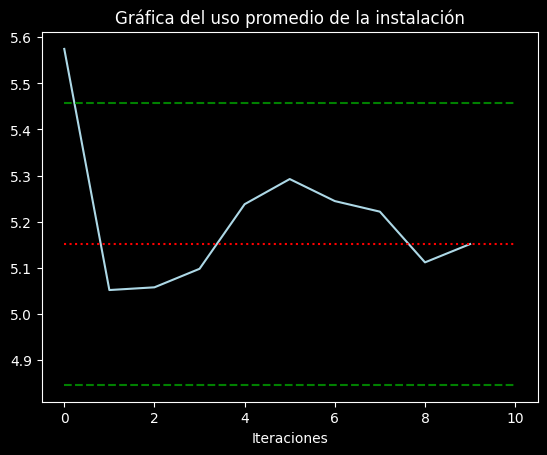

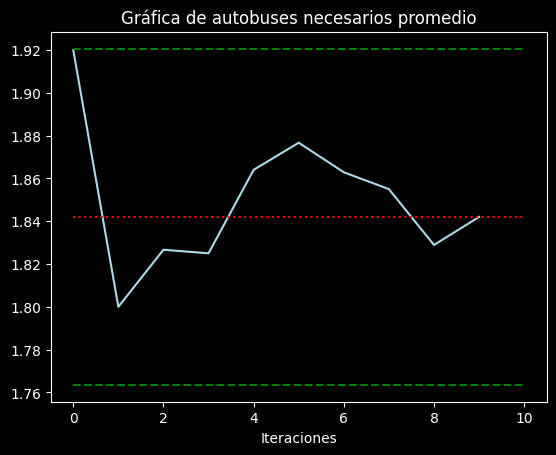

In [19]:
# Ejecutar la simulación y graficar
plt.style.use('dark_background')
graf_estado(a, 'Gráfica de la longitud promedio de la cola (fila)')
graf_estado(b, 'Gráfica del tiempo de espera promedio')
graf_estado(c, 'Gráfica del uso promedio de la instalación')

# Graficar los autobuses necesarios
graf_estado(d, 'Gráfica de autobuses necesarios promedio')

In [20]:
# Realizar replicaciones para obtener intervalos de confianza
def rep(n, nr):
    la, lb, lc, ld = [], [], [], []
    for _ in range(nr):
        a, b, c, d = exp(n)
        la.append(np.mean(a))
        lb.append(np.mean(b))
        lc.append(np.mean(c))
        ld.append(np.mean(d))
    return la, lb, lc, ld

In [24]:
n = 100
nr = 20
a, b, c,d = rep(n, nr)

In [25]:
# Cálculo de intervalos de confianza al 95%
ma, mb, mc, md = np.mean(a), np.mean(b), np.mean(c), np.mean(d)
sa, sb, sc, sd = np.std(a, ddof=1), np.std(b, ddof=1), np.std(c, ddof=1), np.std(d, ddof=1)
t_student = t.ppf(0.975, nr-1)

intervalo_a = (ma - t_student * sa / np.sqrt(nr), ma + t_student * sa / np.sqrt(nr))
intervalo_b = (mb - t_student * sb / np.sqrt(nr), mb + t_student * sb / np.sqrt(nr))
intervalo_c = (mc - t_student * sc / np.sqrt(nr), mc + t_student * sc / np.sqrt(nr))
intervalo_d = (md - t_student * sd / np.sqrt(nr), md + t_student * sd / np.sqrt(nr))


In [26]:
# Imprimir resultados
print(f"Intervalo de confianza para la longitud promedio de la cola: {intervalo_a}")
print(f"Intervalo de confianza para el tiempo de espera promedio: {intervalo_b}")
print(f"Intervalo de confianza para el uso promedio de la instalación: {intervalo_c}")
print(f"Intervalo de confianza para los autobuses necesarios: {intervalo_d}")

Intervalo de confianza para la longitud promedio de la cola: (0.01573477960931159, 0.017203320964082294)
Intervalo de confianza para el tiempo de espera promedio: (0.31469559218623183, 0.3440664192816459)
Intervalo de confianza para el uso promedio de la instalación: (4.919710511440563, 5.27073010925727)
Intervalo de confianza para los autobuses necesarios: (1.777059729562653, 1.8609402704373466)
